### Objetivo 1: Analizar la distribución de la población a nivel municipal, considerando variables demográficas como el tamaño poblacional y su estructura por grupos de edad.

In [2]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
import numpy as np

In [3]:
path = "../data/combined/centros_sanitarios_poblacion_municipios.csv"
df = pd.read_csv(path)

In [4]:
# Compute population density (people per hectare)
df["density"] = df["poblacion_total"] / df["area_ha"]

# Convert geometry column to shapely objects
# (This assumes geometry_municipio is WKT format)
df["geometry"] = df["geometry_municipio"].apply(wkt.loads)



In [5]:
# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

Representamos la densidad de población en escala logarítmica para facilitar la interpretación de las diferencias entre municipios.

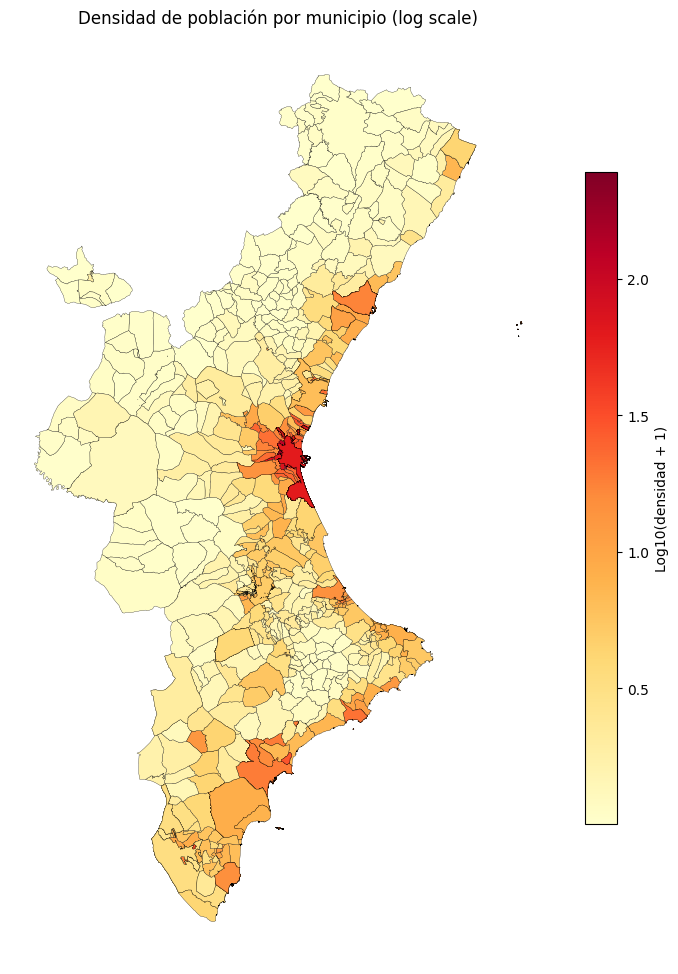

In [15]:
# Log-transform the density
gdf["log_density"] = np.log10(gdf["density"] + 1)

fig, ax = plt.subplots(figsize=(8, 10))

gdf.plot(
    column="log_density",
    cmap="YlOrRd",
    legend=True,
    edgecolor="black",
    linewidth=0.2,
    ax=ax,
    legend_kwds={
        "label": "Log10(densidad + 1)",
        "shrink": 0.7
    }
)

ax.set_aspect("equal")
ax.set_title("Densidad de población por municipio (log scale)")
ax.set_axis_off()

plt.tight_layout()

plt.savefig("../graficas/densidad_poblacion_por_municipio.pdf", bbox_inches="tight")

plt.show()

### Objetivo 2: Estudiar la distribución territorial de los centros sanitarios (hospitales, centros de especialidades y centros de salud) en el ámbito de la Comunitat Valenciana.

In [25]:
import numpy as np

# Avoid division by zero
gdf = gdf[gdf["area_ha"] > 0].copy()

gdf["density"] = gdf["poblacion_total"] / gdf["area_ha"]
gdf["log_density"] = np.log10(gdf["density"] + 1)

In [26]:
gdf["log_density"].isna().sum(), np.isinf(gdf["log_density"]).sum()

(0, 0)

In [29]:
# Remove rows with missing geometry
gdf = gdf[gdf.geometry.notna()].copy()

# Remove empty geometries
gdf = gdf[~gdf.geometry.is_empty].copy()

print("Geometries after cleaning:", len(gdf))


Geometries after cleaning: 682


In [30]:
import numpy as np

# Remove zero or negative areas
gdf = gdf[gdf["area_ha"] > 0].copy()

gdf["density"] = gdf["poblacion_total"] / gdf["area_ha"]
gdf["log_density"] = np.log10(gdf["density"] + 1)

print("NaN log_density:", gdf["log_density"].isna().sum())
print("Inf log_density:", np.isinf(gdf["log_density"]).sum())


NaN log_density: 0
Inf log_density: 0


In [31]:
# Reproject
gdf = gdf.to_crs(epsg=25830)

# Representative points
gdf["rep_point"] = gdf.geometry.representative_point()

# Filter municipios with health center
gdf_centros = gdf[gdf["tiene_centro_sanitario"] == 1]


In [32]:
bounds = gdf.total_bounds
print("Bounds:", bounds)

# Only set limits if bounds are valid
if np.all(np.isfinite(bounds)):
    minx, miny, maxx, maxy = bounds
else:
    print("⚠️ Bounds contain NaN/Inf — skipping manual axis limits.")


Bounds: [inf inf inf inf]
⚠️ Bounds contain NaN/Inf — skipping manual axis limits.


In [34]:
print(df["geometry_municipio"].head(5))
print(df["geometry_municipio"].isna().sum())

0    MULTIPOLYGON (((743276.308117251 4304914.60798...
1    MULTIPOLYGON (((704600.791944247 4263369.91113...
2    MULTIPOLYGON (((714462.985510726 4293839.55211...
3    MULTIPOLYGON (((731854.929641063 4267367.66736...
4    MULTIPOLYGON (((689973.260835391 4229818.12367...
Name: geometry_municipio, dtype: object
0


In [35]:
from shapely import wkt

# Convert WKT to geometry
df["geometry"] = df["geometry_municipio"].apply(lambda x: wkt.loads(x) if pd.notna(x) else None)

# Check
print(df["geometry"].head())
print("Any empty geometries:", df["geometry"].isna().sum())


0    MULTIPOLYGON (((743276.308117251 4304914.60798...
1    MULTIPOLYGON (((704600.791944247 4263369.91113...
2    MULTIPOLYGON (((714462.985510726 4293839.55211...
3    MULTIPOLYGON (((731854.929641063 4267367.66736...
4    MULTIPOLYGON (((689973.260835391 4229818.12367...
Name: geometry, dtype: object
Any empty geometries: 0


In [36]:
import geopandas as gpd

gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")


In [37]:
gdf = gdf[gdf.geometry.notna() & ~gdf.geometry.is_empty].copy()


In [38]:
print("Invalid geometries:", (~gdf.is_valid).sum())
# Fix invalid ones (optional)
gdf["geometry"] = gdf.buffer(0)


Invalid geometries: 3


In [39]:
gdf = gdf.to_crs(epsg=25830)
gdf["rep_point"] = gdf.geometry.representative_point()
gdf_centros = gdf[gdf["tiene_centro_sanitario"] == 1]


KeyError: 'log_density'

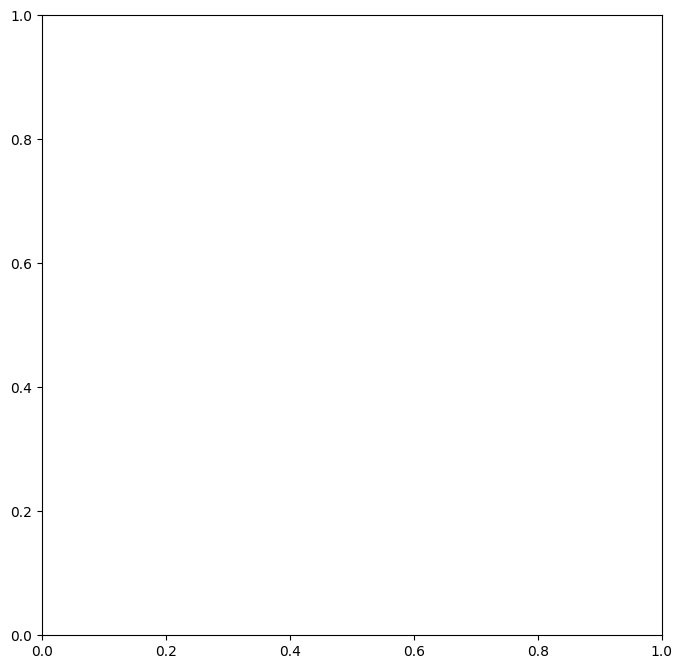

In [40]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 10))

# Base map
gdf.plot(
    column="log_density",
    cmap="YlOrRd",
    legend=True,
    edgecolor="black",
    linewidth=0.2,
    ax=ax,
    legend_kwds={
        "label": "Log10(Densidad de población + 1)",
        "shrink": 0.7
    }
)

# Triangles
ax.scatter(
    gdf_centros.rep_point.x,
    gdf_centros.rep_point.y,
    marker="^",
    s=60,
    facecolors="white",
    edgecolors="black",
    linewidths=0.8,
    label="Municipio con centro sanitario",
    zorder=5
)

# Apply bounds only if valid
if np.all(np.isfinite(bounds)):
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

ax.set_aspect("equal")
ax.set_title("Densidad de población y centros sanitarios (escala logarítmica)")
ax.set_axis_off()
ax.legend(loc="upper right")

plt.tight_layout()
plt.savefig("densidad_poblacion_centros.pdf", bbox_inches="tight")
plt.show()


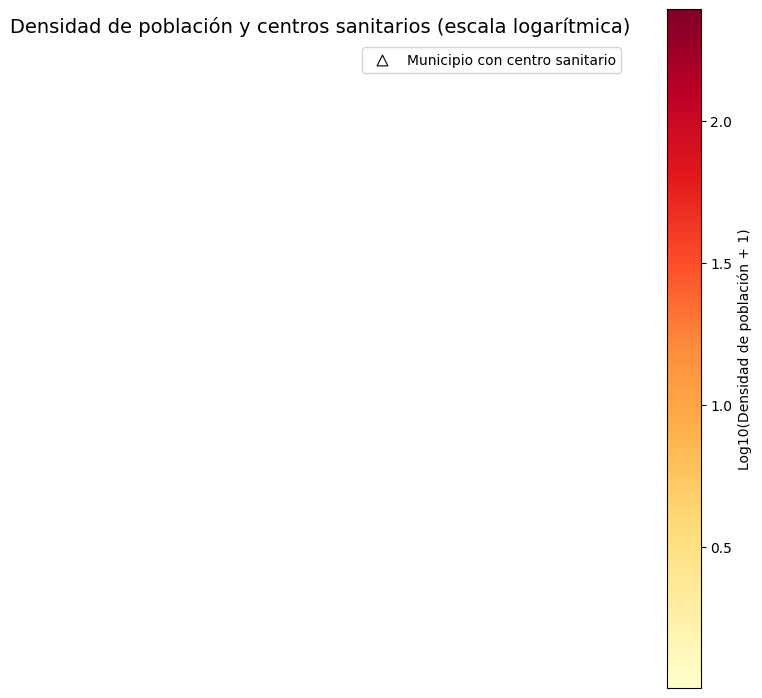

In [41]:
# Full working script for population density map with health centers

import pandas as pd
import geopandas as gpd
from shapely import wkt
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 1️⃣ Load CSV
# -------------------------------
path = "../data/combined/centros_sanitarios_poblacion_municipios.csv"
df = pd.read_csv(path)

# -------------------------------
# 2️⃣ Convert geometry column (WKT) to Shapely
# -------------------------------
df["geometry"] = df["geometry_municipio"].apply(lambda x: wkt.loads(x) if pd.notna(x) else None)

# Drop rows with missing geometry
df = df[df["geometry"].notna()].copy()

# -------------------------------
# 3️⃣ Create GeoDataFrame
# -------------------------------
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

# -------------------------------
# 4️⃣ Remove empty or invalid geometries
# -------------------------------
gdf = gdf[~gdf.geometry.is_empty].copy()

# Optional: fix invalid geometries
gdf["geometry"] = gdf.buffer(0)

# -------------------------------
# 5️⃣ Compute population density
# -------------------------------
# Avoid division by zero
gdf = gdf[gdf["area_ha"] > 0].copy()

gdf["density"] = gdf["poblacion_total"] / gdf["area_ha"]
gdf["log_density"] = np.log10(gdf["density"] + 1)

# -------------------------------
# 6️⃣ Reproject to metric CRS (UTM Spain) for accurate plotting
# -------------------------------
gdf = gdf.to_crs(epsg=25830)

# Representative points for placing triangles
gdf["rep_point"] = gdf.geometry.representative_point()

# Filter municipios with health center
gdf_centros = gdf[gdf["tiene_centro_sanitario"] == 1]

# -------------------------------
# 7️⃣ Plot
# -------------------------------
fig, ax = plt.subplots(figsize=(8, 10))

# Choropleth map
gdf.plot(
    column="log_density",
    cmap="YlOrRd",
    legend=True,
    edgecolor="black",
    linewidth=0.2,
    ax=ax,
    legend_kwds={
        "label": "Log10(Densidad de población + 1)",
        "shrink": 0.7
    }
)

# Overlay triangles for health centers
ax.scatter(
    gdf_centros.rep_point.x,
    gdf_centros.rep_point.y,
    marker="^",
    s=60,
    facecolors="white",
    edgecolors="black",
    linewidths=0.8,
    label="Municipio con centro sanitario",
    zorder=5
)

# Set correct aspect
ax.set_aspect("equal")
ax.set_title("Densidad de población y centros sanitarios (escala logarítmica)", fontsize=14)
ax.set_axis_off()

# Legend for triangles
ax.legend(loc="upper right")

plt.tight_layout()

# -------------------------------
# 8️⃣ Save figure as PDF
# -------------------------------
plt.savefig("densidad_poblacion_centros.pdf", bbox_inches="tight")

# Show figure
plt.show()
